In [1]:
import torch
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data = np.genfromtxt('toydataset.txt', delimiter='\t')
x = data[:, :2].astype(np.float32)
y = data[:, 2].astype(np.int64)

In [3]:
np.random.seed(123)
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X_test, y_test = x[idx[:25]], y[idx[:25]]
X_train, y_train = x[idx[25:]], y[idx[25:]]
mu, std = np.mean(X_train, axis=0), np.std(X_train, axis=0)
X_train, X_test = (X_train - mu) / std, (X_test - mu) / std

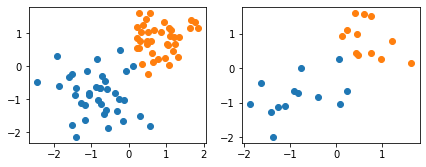

In [4]:
# Plot two subplots

fig, ax = plt.subplots(1, 2, figsize=(7, 2.5))

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1])
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1])

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1])
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1])

plt.show()

In [5]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.linear = torch.nn.Linear(num_features, 1)
        
    def forward(self, X):
        logits = self.linear(X)
        probas = torch.sigmoid(logits)
        return probas

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print(f"Running on {torch.cuda.get_device_name()}")
else:
    device = torch.device("cpu")

Running on NVIDIA GeForce RTX 3080


In [7]:
model = LogisticRegression(num_features=2).to(device)

In [8]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[0.2790, 0.5923]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.1894], device='cuda:0', requires_grad=True)


In [9]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

In [11]:
def comp_accuracy(label_var, pred_probas):
    pred_labels = torch.where((pred_probas > 0.5), 1, 0).view(-1)
    acc = torch.sum(pred_labels == label_var.view(-1)).float() / label_var.size(0)
    return acc

EPOCHS = 30

X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1,1)

for epoch in range(EPOCHS):
    pred = model(X_train_tensor)
    loss = F.binary_cross_entropy(pred, y_train_tensor, reduction="sum")
    
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
    
    pred_probas = model(X_train_tensor)
    acc = comp_accuracy(y_train_tensor, pred_probas)
    print(f"Epoch: {epoch+1} Accuracy: {acc}  Loss: {loss}")
    
print(f"Weights: {model.linear.weight}")
print(f"Bias: {model.linear.bias}")

Epoch: 1 Accuracy: 0.9733333587646484  Loss: 30.79836082458496
Epoch: 2 Accuracy: 0.9733333587646484  Loss: 5.611514091491699
Epoch: 3 Accuracy: 0.9733333587646484  Loss: 3.1050500869750977
Epoch: 4 Accuracy: 0.9866666793823242  Loss: 2.4962568283081055
Epoch: 5 Accuracy: 0.9866666793823242  Loss: 2.13830304145813
Epoch: 6 Accuracy: 0.9866666793823242  Loss: 1.8225390911102295
Epoch: 7 Accuracy: 1.0  Loss: 1.5280553102493286
Epoch: 8 Accuracy: 1.0  Loss: 1.2645173072814941
Epoch: 9 Accuracy: 1.0  Loss: 1.0431692600250244
Epoch: 10 Accuracy: 1.0  Loss: 0.8751689195632935
Epoch: 11 Accuracy: 1.0  Loss: 0.7521300911903381
Epoch: 12 Accuracy: 1.0  Loss: 0.6622260808944702
Epoch: 13 Accuracy: 1.0  Loss: 0.5980237126350403
Epoch: 14 Accuracy: 1.0  Loss: 0.5439622402191162
Epoch: 15 Accuracy: 1.0  Loss: 0.4994763135910034
Epoch: 16 Accuracy: 1.0  Loss: 0.45763444900512695
Epoch: 17 Accuracy: 1.0  Loss: 0.4179539680480957
Epoch: 18 Accuracy: 1.0  Loss: 0.37993207573890686
Epoch: 19 Accuracy: 1

In [12]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

pred_probas = model(X_test_tensor)
test_acc = comp_accuracy(y_test_tensor, pred_probas)

print('Test set accuracy: %.2f%%' % (test_acc*100))

Test set accuracy: 96.00%


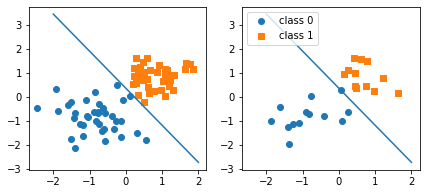

In [17]:
w, b = model.linear.weight.detach().cpu().view(-1).numpy(), model.linear.bias.detach().cpu().numpy()

x_min = -2
y_min = ( (-(w[0] * x_min) - b[0]) 
          / w[1] )

x_max = 2
y_max = ( (-(w[0] * x_max) - b[0]) 
          / w[1] )


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))
ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()